In [1]:
import numpy as np
import math
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torch.multiprocessing as mp
from datetime import datetime

import pdb

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Utils
import data_generator

import classical_newsvendor_utils


from os import listdir
from os.path import isfile, join

In [2]:
is_cuda = False
dev = torch.device('cpu')  
if torch.cuda.is_available():
    is_cuda = True
    dev = torch.device('cuda')  

In [3]:
# Setting the seeds to allow replication
# Changing the seed might require hyperparameter tuning again
# Because it changes the deterministic parameters
seed_number = 42
np.random.seed(seed_number)
torch.manual_seed(seed_number)
random.seed(seed_number)

In [4]:
N_test = 3000

X, y = data_generator.data_1to1(N_test)

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

for k in [1.0, 10.0, 50.0, 100.0, 300.0, 1000.0]:
    !source /home/alan/Desktop/envs/pao_env/bin/activate && python3 classic_newsvendor.py {k} 2.0

for eps in [0.0, 0.1, 1.0, 5.0, 10.0, 30.0]:
    !source /home/alan/Desktop/envs/pao_env/bin/activate && python3 classic_newsvendor.py {eps}

In [5]:
models_path = './models/'
csvs_path = './newsvendor_results/'
csv_names = [f for f in listdir(csvs_path) if isfile(join(csvs_path, f))]

In [6]:
import pandas as pd

In [7]:
df_results = pd.DataFrame()

for cn in csv_names:
    csv_name = cn
    model_name = cn.replace('csv','pkl')

    df_aux = pd.read_csv(csvs_path+csv_name)
    df_aux = df_aux.set_index('Unnamed: 0')
    df_aux.columns = [csv_name]
    
    df_results = pd.concat([df_results, df_aux], axis=1)

In [8]:
df_results.loc[0.8]

elbo_nv1_500_20_nr.csv      0.074
elbo_nv1_100_20_nr.csv      0.083
elbo_nv1_10000_20_nr.csv    0.107
elbo_nv1_01_20_nr.csv       0.098
mse_nv1_00_nr.csv           0.101
mse_nv1_1000_nr.csv         0.567
mse_nv1_100_nr.csv          0.092
mse_nv1_50_nr.csv           0.085
elbo_nv1_1000_20_nr.csv     0.076
mse_nv1_300_nr.csv          0.174
mse_nv1_01_nr.csv           0.100
elbo_nv1_10_20_nr.csv       0.088
mse_nv1_10_nr.csv           0.093
elbo_nv1_3000_20_nr.csv     0.091
Name: 0.8, dtype: float64

In [9]:
model_name_mse = "mse_nv1_00.pkl"
model_name_mse_noise = "mse_nv1_50.pkl"
model_name_bnn_bayes = "elbo_nv1_500_20.pkl"

In [10]:
model_mse = torch.load(f'./models/{model_name_mse}')
model_mse_noise = torch.load(f'./models/{model_name_mse_noise}')
model_bnn_bayes = torch.load(f'./models/{model_name_bnn_bayes}')

In [11]:
model_mse_noise.update_n_samples(1000)
model_bnn_bayes.update_n_samples(1000)

In [12]:
def plot_regression(X, y, model, method):

    xt = torch.hstack(
        (X[:,0], 
         torch.tensor(np.arange(-1.4, -1, 1/500), dtype = torch.float32), 
         torch.tensor(np.arange(1, 1.4, 1/500), dtype = torch.float32)))

    fig, ax = plt.subplots(figsize=(8,4), dpi=120)
    ax.scatter(X[:,0].detach(), y.detach(), color='b', label='Valid. Output')
    
    if method in ['BNN', 'ANN_NOISE']:
        y_pred = model.forward_dist(xt.unsqueeze(1))
        for i in range(0, 100):
            ax.scatter(xt.detach(), y_pred.detach().squeeze()[i],
                        color='r', alpha=0.01)
            ax.set_ylim([-1, 10])
        K = '50'
        PLV = '02'
    elif method in ['ANN']:
        K = '0'
        PLV = '0'
        ax.scatter(X.detach().numpy(), 
                        model(X).detach().numpy(), 
                        color='r', alpha=0.5)
    else:
        print('Not a valid method')
        exit()
        
    fig.suptitle(f'Regression 1D fit. Method: {method}')
    ax.set_xlabel('Input')
    ax.set_ylabel('Output')

    legend_elements = [Line2D([0], [0], color='r', lw=2, label='Pred. Output'),
                   Line2D([0], [0], marker='o', color='w', label='Valid. Output',
                          markerfacecolor='b', markersize=15)]

    ax.legend(handles=legend_elements, loc='upper right')
    #fig.savefig(f'./figures/regression_{K}_{PLV}.png')

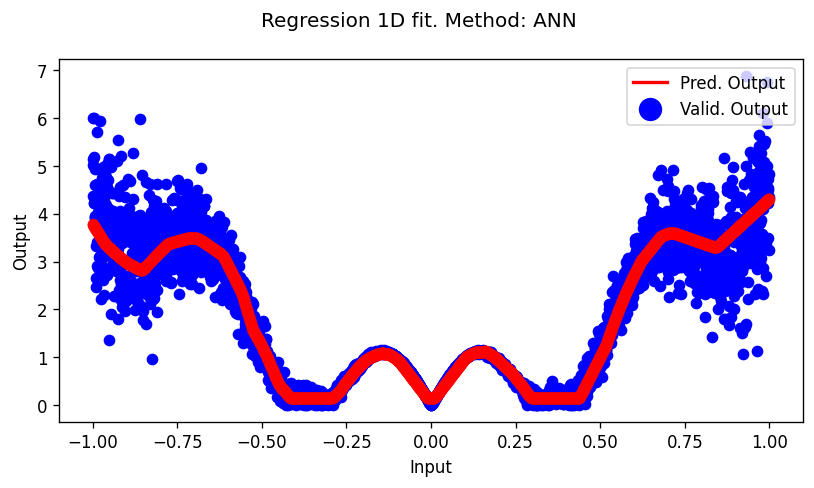

In [13]:
plot_regression(X, y, model_mse, 'ANN')

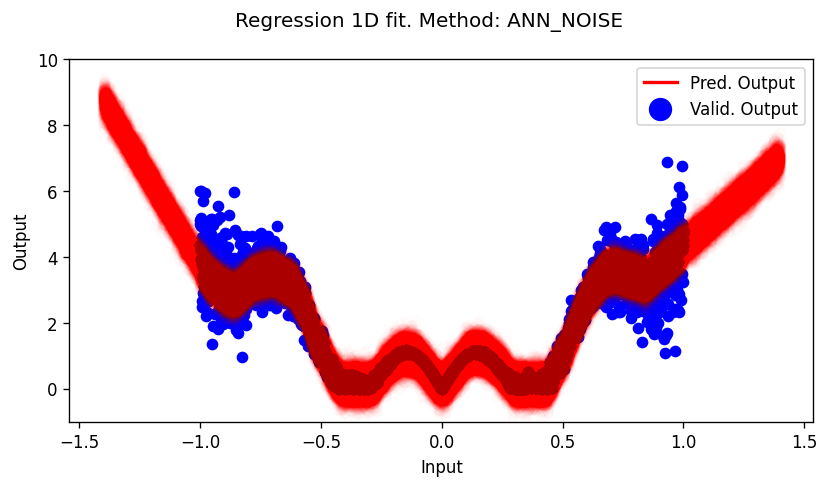

In [14]:
plot_regression(X, y, model_mse_noise, 'ANN_NOISE')

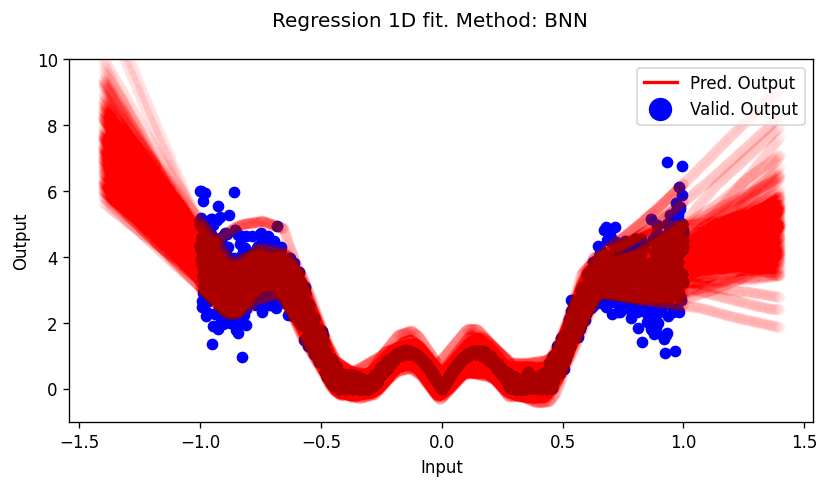

In [15]:
plot_regression(X, y, model_bnn_bayes, 'BNN')

In [39]:
def compute_nv_curve(X, y, model, M=1000):
    sell_price = 200
    dict_results_nr = {}
    for cost_price in (np.arange(0.1,1,0.1)*sell_price):
        quantile = (sell_price-cost_price)/sell_price
        dict_results_nr[quantile] = round(
            classical_newsvendor_utils.compute_norm_regret(
            X, y, model, M, sell_price, cost_price).item(), 
            3)
    return dict_results_nr

In [40]:
nr_ann = compute_nv_curve(X, y, model_mse, M=1000)
nr_ann_noise = compute_nv_curve(X, y, model_mse_noise, M=1000)
nr_bnn = compute_nv_curve(X, y, model_bnn_bayes, M=1000)

Text(0.5, 0, 'Newsvendor Quantile: (sell_price-cost_price)/sell_price')

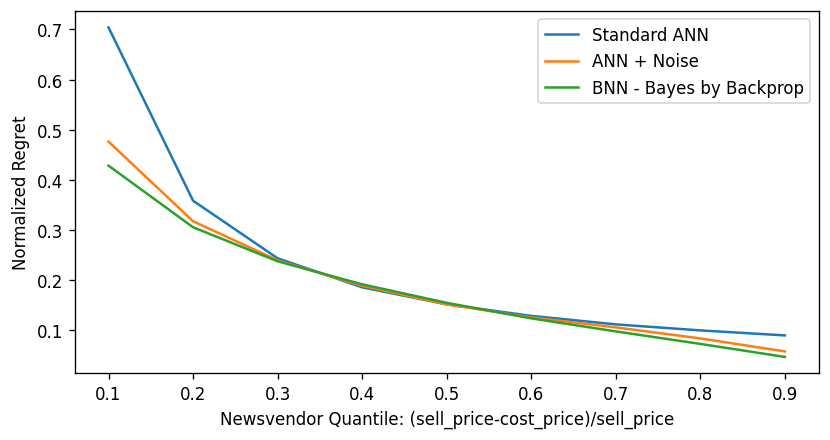

In [44]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=120)
ax.plot(nr_ann.keys(), nr_ann.values(), label='Standard ANN')
ax.plot(nr_ann_noise.keys(), nr_ann_noise.values(), label='ANN + Noise')
ax.plot(nr_bnn.keys(), nr_bnn.values(), label='BNN - Bayes by Backprop')
ax.legend()

ax.set_ylabel('Normalized Regret')
ax.set_xlabel('Newsvendor Quantile: (sell_price-cost_price)/sell_price')